In [1]:
import gym
import random
import numpy as np
import copy
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore")

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make('MountainCar-v0')
n_actions = env.action_space.n
n_states = env.observation_space.shape[0]

In [12]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

#### Буфер для experience replay

In [13]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

#### Класс для DQN

In [14]:
class DQN:
    def __init__(self, layers, lr=0.0005, optim_method=optim.Adam):
        self.layers = layers
        self.lr = lr
        self.loss = F.mse_loss
        self.optim_method = optim_method
        self.TargetNetwork = None
        self.EstimateNetwork = None
        self.optimizer = None
        self.build_model()

    def build_model(self):
        def init_weights(layer):
            if type(layer) == nn.Linear:
                nn.init.xavier_normal_(layer.weight)

        self.EstimateNetwork = nn.Sequential(*self.layers)
        self.EstimateNetwork.apply(init_weights)

        layers_for_target = copy.deepcopy(self.layers)
        self.TargetNetwork = nn.Sequential(*layers_for_target)
        self.TargetNetwork.load_state_dict(self.EstimateNetwork.state_dict())

        self.optimizer = self.optim_method(self.EstimateNetwork.parameters(), lr=self.lr)

    def Q_target(self, inp):
        return self.TargetNetwork(inp)

    def Q_estimate(self, inp):
        return self.EstimateNetwork(inp)

    def update_target(self):
        self.TargetNetwork.load_state_dict(self.EstimateNetwork.state_dict())

    def update_parameters(self, estimated, targets):
        loss = self.loss(estimated, targets.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()

        for param in self.EstimateNetwork.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def save(self, name):
        torch.save(self.EstimateNetwork, name)
        print('------ Model saved ------')

#### Класс для агента

In [15]:
class Agent:
    def __init__(self, env, Model, n_actions, goal, min_score, \
                 eps_start=1, eps_end=0.001, eps_decay=0.9, gamma=0.99, \
                 batch_size=64, memory_size=100000, max_episode=2000, upd_rate=1):
        self.env = env 
        self.n_actions = n_actions # number of possible actions
        self.goal = goal # the score to reach during learning
        self.min_score = min_score # min score to complete the episode
        self.eps_start = eps_start 
        self.eps = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update_rate = upd_rate # how often we update our target network
        self.Model = Model # DQN instance
        self.max_episode = max_episode # how long we train our agent
        self.memory = ReplayMemory(memory_size) # Replay buffer

    def act(self, state, eps): # epsilon greedy policy
        if random.random() < eps:
            return torch.tensor([[random.randrange(self.n_actions)]], device=device, dtype=torch.long)
        else:
            with torch.no_grad():
                result = self.Model.Q_estimate(state).max(1)[1]
                return result.view(1, 1)

    def optimize(self): # experience replay 
        if len(self.memory) < self.batch_size:
            return

        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        next_state_batch = torch.cat(batch.next_state)
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.cat(batch.done)

        estimate_value = self.Model.Q_estimate(state_batch).gather(1, action_batch)

        Q_value_next = torch.zeros(self.batch_size, device=device)
        with torch.no_grad():
            Q_value_next[~done_batch] = self.Model.Q_target(next_state_batch).max(1)[0].detach()[~done_batch]
        target_value = (Q_value_next * self.gamma) + reward_batch

        self.Model.update_parameters(estimate_value, target_value)

    def train(self): # learning procedure 
        all_scores = []
        successful_sequences = 0
        for ep in range(1, self.max_episode + 1):
            state = self.env.reset()
            state = torch.tensor(state).to(device).float().unsqueeze(0)
            done = False
            episode_reward = 0

            while not done:
                action = self.act(state, self.eps) 
                action = torch.tensor(action).to(device)

                next_state, reward, done, info = self.env.step(action.item())
                episode_reward += reward

                modified_reward = reward + 300 * (self.gamma * abs(next_state[1]) - abs(state[0][1]))

                next_state = torch.tensor(next_state).to(device).float().unsqueeze(0)
                modified_reward = torch.tensor(modified_reward).to(device).float().unsqueeze(0)
                done = torch.tensor(done).to(device).unsqueeze(0)

                self.memory.push(state, action, next_state, modified_reward, done)
                state = next_state

                self.optimize() # experience replay

            
            if ep % self.target_update_rate == 0: 
                self.Model.update_target()

            self.eps = max(self.eps_end, self.eps * self.eps_decay)
            all_scores.append(episode_reward)

            if ep % 100 == 0:
                print('episode', ep, ':', np.mean(all_scores[:-100:-1]), 'average score')

            if np.mean(all_scores[:-100:-1]) >= self.goal:
                successful_sequences += 1
                if successful_sequences == 5:
                    print('success at episode', ep)
                    return all_scores
            else:
                successful_sequences = 0

        return all_scores

    def test(self, episodes=50, render=False): #test trained agent
        state = self.env.reset()
        state = torch.tensor(state).to(device).float().unsqueeze(0)
        ep_count = 0
        current_episode_reward = 0
        scores = []
        while ep_count < episodes:
            if render:
                env.render()
            action = self.act(state, 0)
            state, reward, done, _ = self.env.step(action.item())
            state = torch.tensor(state).to(device).float().unsqueeze(0)
            current_episode_reward += reward

            if done:
                ep_count += 1
                scores.append(current_episode_reward)
                current_episode_reward = 0
                state = self.env.reset()
                state = torch.tensor(state).to(device).float().unsqueeze(0)

        print('average score:', sum(scores) / len(scores))
        print('max reward:', max(scores))
        print('-----')
        print()

    def save(self, name='agent.pkl'): # save policy network
        self.Model.save(name)

#### Инициализация агента и обучение

In [16]:
layers = (
        nn.Linear(n_states, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, n_actions),
)

In [26]:
Model = DQN(layers, lr=0.0001, optim_method=optim.Adam)
MountainCarAgent = Agent(env, Model, n_actions, goal=-110, min_score=-200, \
                         eps_start=1, eps_end=0.001, eps_decay=0.9, gamma=0.99, \
                         batch_size=64, memory_size=100000, max_episode=2000)
scores = MountainCarAgent.train()

episode 100 : -198.1818181818182 average score
episode 200 : -198.84848484848484 average score
episode 300 : -179.44444444444446 average score
episode 400 : -176.03030303030303 average score
episode 500 : -157.94949494949495 average score
episode 600 : -157.44444444444446 average score
episode 700 : -145.2020202020202 average score
episode 800 : -127.29292929292929 average score
episode 900 : -110.4040404040404 average score
success at episode 936


##### Протестируем агента и выведем средний скор за 100 эпизодов

In [27]:
MountainCarAgent.test()

average score: -102.68
max reward: -84.0
-----



##### История обучения

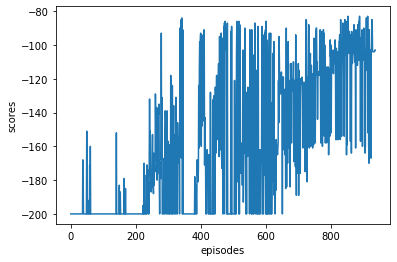

In [29]:
episodes = range(len(scores))
plt.plot(episodes, scores)
plt.xlabel('episodes')
plt.ylabel('scores')
plt.show()